<a href="https://colab.research.google.com/github/gizattos/diabetes_classification/blob/master/Classifica%C3%A7%C3%A3o%20de%20pacientes%20com%20diabetes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Utilizando o dataset "Pima Indians Diabetes Database" crie um modelo para diagnosticar um paciente como diabético ou não. Discuta sobre a tarefa, o dataset, valores nulos, feature engineering, escolha do modelo, avaliação do modelo, importância das featires, métricas escolhidas (e porquê) e matriz de confusão.

In [0]:
## bibliotecas 
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
from sklearn import tree
from sklearn.metrics import plot_confusion_matrix, plot_roc_curve, plot_precision_recall_curve, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
import seaborn as sns
import numpy as np 
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

<h1>Variáveis</h1>

Pregnancies: Number of pregnancies <br>
Glucose: Plasma glucose concentration a 2 hours in an oral glucose tolerance test<br>
BloodPressure: Diastolic blood pressure (mm Hg)<br>
SkinThickness: Triceps skin fold thickness (mm)<br>
Insulin: 2-Hour serum insulin (mu U/ml)<br>
BMI: Body mass index (weight in kg/(height in m)^2) <br>
DiabetesPedigreeFunction:Diabetes pedigree function<br>
Age:Age (years) <br>
Outcome: Class variable (0 or 1) 268 of 768 are 1, the others are 0








<h2> Lendo CSV </h2>



In [0]:
df = pd.read_csv('/content/diabetes.csv')

In [409]:
df

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1


<h2>Explorando dataset</h2>

In [410]:
## dados faltantes
df.isna().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

In [411]:
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


De acordo com o artigo https://www.sciencedirect.com/science/article/pii/S2352914816300016 , em alguns casos o valor 0 foi posto no lugar de valores faltantes, não possibilitando saber quando é um missing ou quando é um valor real

In [412]:
## quantidade de zeros por coluna
(df == 0).sum()

Pregnancies                 111
Glucose                       5
BloodPressure                35
SkinThickness               227
Insulin                     374
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
Outcome                     500
dtype: int64

In [0]:
## trocando valores das colunas Glucose, BloodPressure , SkinThickness , Insulin , BMI pela mediana
median_Glucose = df['Glucose'].median(skipna=True)
median_BloodPressure = df['BloodPressure'].median(skipna=True)
median_SkinThickness = df['SkinThickness'].median(skipna=True)
median_Insulin = df['Insulin'].median(skipna=True)
median_BMI = df['BMI'].median(skipna=True)
df=df.replace({'Glucose': {0: median_Glucose}})
df=df.replace({'BloodPressure': {0: median_BloodPressure}}) 
df=df.replace({'SkinThickness': {0: median_SkinThickness}}) 
df=df.replace({'Insulin': {0: median_Insulin}}) 
df=df.replace({'BMI': {0: median_BMI}})  


In [414]:
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,121.656250,72.386719,27.334635,94.652344,32.450911,0.471876,33.240885,0.348958
std,3.369578,30.438286,12.096642,9.229014,105.547598,6.875366,0.331329,11.760232,0.476951
min,0.000000,44.000000,24.000000,7.000000,14.000000,18.200000,0.078000,21.000000,0.000000
25%,1.000000,99.750000,64.000000,23.000000,30.500000,27.500000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,31.250000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


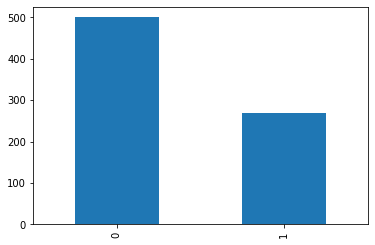

In [415]:
## quantidade de pacientes com diabetes e sem diabetes
df['Outcome'].value_counts().plot(kind='bar')

In [416]:
## correlação entre variáveis para visualizar se existe alguma variável explicativa com correlação muito alta com outra
df.corr()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
Pregnancies,1.000000,0.128213,0.208615,0.032568,-0.055697,0.021546,-0.033523,0.544341,0.221898
Glucose,0.128213,1.000000,0.218937,0.172143,0.357573,0.231400,0.137327,0.266909,0.492782
BloodPressure,0.208615,0.218937,1.000000,0.147809,-0.028721,0.281132,-0.002378,0.324915,0.165723
SkinThickness,0.032568,0.172143,0.147809,1.000000,0.238188,0.546951,0.142977,0.054514,0.189065
Insulin,-0.055697,0.357573,-0.028721,0.238188,1.000000,0.189022,0.178029,-0.015413,0.148457
BMI,0.021546,0.231400,0.281132,0.546951,0.189022,1.000000,0.153506,0.025744,0.312249
DiabetesPedigreeFunction,-0.033523,0.137327,-0.002378,0.142977,0.178029,0.153506,1.000000,0.033561,0.173844
Age,0.544341,0.266909,0.324915,0.054514,-0.015413,0.025744,0.033561,1.000000,0.238356
Outcome,0.221898,0.492782,0.165723,0.189065,0.148457,0.312249,0.173844,0.238356,1.000000


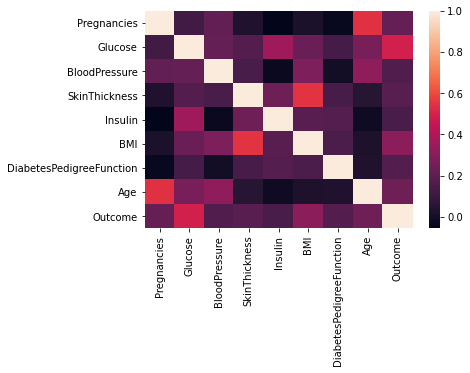

In [417]:
## plotando correlação
sns.heatmap(df.corr())

In [0]:
## definindo X e Y
x = df.drop(['Outcome'],axis=1) 
y = df['Outcome']

<h2>Descision Tree</h2>

In [419]:
## Separando em treino e teste
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=42)
dt = tree.DecisionTreeClassifier(criterion='entropy', random_state = 42)
dt.fit(x_train,y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=42, splitter='best')

In [0]:
## predizendo x_test
y_pred = dt.predict(x_test)

In [421]:
## importancia de cada variável
print(dt.feature_importances_)
print(x.columns)

[0.09989269 0.24966088 0.10951578 0.06404277 0.06552228 0.11688001
 0.09616823 0.19831735]
Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age'],
      dtype='object')


Podemos visualizar que de todas as variáveis, Glucose, BMI, Age e BloodPressure são as mais importantes pro modelo

In [422]:
## matrix de confusão com precisão, recall, f1-scope e support
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[74 25]
 [17 38]]
              precision    recall  f1-score   support

           0       0.81      0.75      0.78        99
           1       0.60      0.69      0.64        55

    accuracy                           0.73       154
   macro avg       0.71      0.72      0.71       154
weighted avg       0.74      0.73      0.73       154



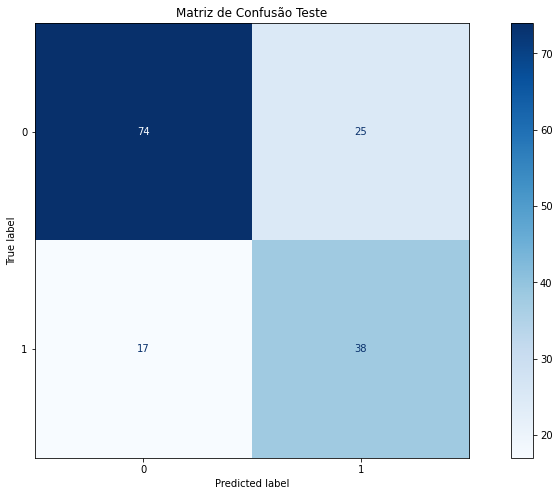

In [423]:
## plotando Matriz de confusão do teste
f, ax = plt.subplots(1,1,figsize=(15,8))

plot_confusion_matrix(dt,x_test,y_test,ax=ax,cmap=plt.cm.Blues,values_format='.4g')

ax.set_title('Matriz de Confusão Teste')

plt.show()

O modelo obteve 73% de acerto, obtendo melhores resultados prevendo resultados 0, onde classificou 74 pessoas corretamente e 25 de forma incorreta. Já para paciente que possuem diabetes o modelo tem um erro maior, classificando corretamente 38 e de forma incorreta 17. Por se tratar de saúde, um acerto menor na classificação da diabetes é um problema, pois assim aproximadamente 39% das pessoas que possuem diabetes, seriam mandadas para casa com um prognóstico incorreto.

In [424]:
## matrix de confusão com precisão, recall, f1-scope e support do treino
y_pred_train = dt.predict(x_train)
print(confusion_matrix(y_train, y_pred_train))
print(classification_report(y_train, y_pred_train))

[[401   0]
 [  0 213]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       401
           1       1.00      1.00      1.00       213

    accuracy                           1.00       614
   macro avg       1.00      1.00      1.00       614
weighted avg       1.00      1.00      1.00       614



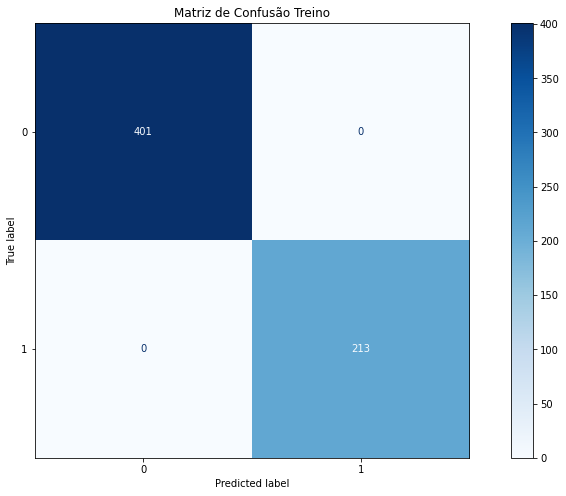

In [425]:
## plotando Matriz de confusão do treino
f, ax = plt.subplots(1,1,figsize=(15,8))

plot_confusion_matrix(dt,x_train,y_train,ax=ax,cmap=plt.cm.Blues,values_format='.4g')

ax.set_title('Matriz de Confusão Treino')

plt.show()

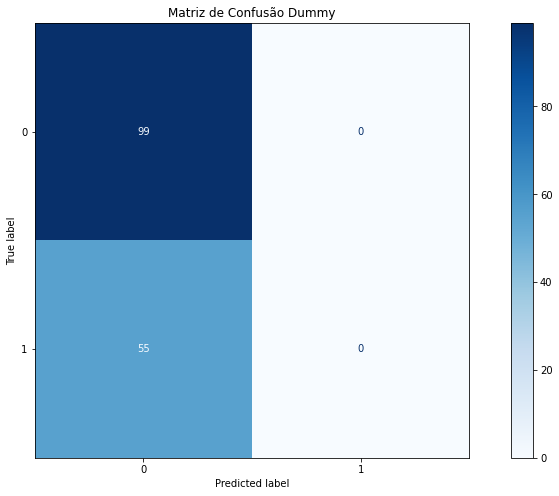

In [426]:
## plotando Matriz de confusão Dummy
f, ax = plt.subplots(1,1,figsize=(15,8))

plot_confusion_matrix(DummyClassifier(strategy='most_frequent').fit(x_train,y_train),x_test,y_test,ax=ax,cmap=plt.cm.Blues,values_format='.4g')

ax.set_title('Matriz de Confusão Dummy')

plt.show()

O modelo de treino acertou 100%, enquanto o modelo de teste teve uma acurácia de 73%, isso é característica de um modelo com overfit, que acabou decorando os dados do treino, possuindo resultados bem diferentes entre treino e teste.<br>Para efeito de comparação também foi plotado uma matriz de confusão utilizando o modelo dummy, esse chegou a 63% de acurácia, mostrando que mesmo o modelo estando overfitado, ainda sim é melhor que o modelo dummy.

In [427]:
## predizendo resultado 
dt.predict([[2,3,4,4,5,3,4,30]])

array([0])

In [428]:
## mostrando probabilidade do resultado
dt.predict_proba([[2,3,4,4,5,3,4,30]])

array([[1., 0.]])

<h2>Random Forest Classification</h2>

In [0]:
# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 1000]
}
rf = RandomForestClassifier()
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

In [430]:
##grid_search.fit(x_train, y_train)
##grid_search.best_params_

Fitting 3 folds for each of 288 candidates, totalling 864 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   19.9s
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 361 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 644 tasks      | elapsed:  5.8min
[Parallel(n_jobs=-1)]: Done 864 out of 864 | elapsed:  7.8min finished


{'bootstrap': True,
 'max_depth': 80,
 'max_features': 2,
 'min_samples_leaf': 4,
 'min_samples_split': 10,
 'n_estimators': 300}

In [0]:
rf = RandomForestClassifier(n_estimators = 2000, random_state = 42)

In [451]:
best_grid = grid_search.best_estimator_
rf = RandomForestClassifier(n_estimators = 2000, random_state = 42,bootstrap = True,
 max_depth = 80,
 max_features= 2,
 min_samples_leaf= 4,
 min_samples_split= 10)
rf.fit(x_train,y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=80, max_features=2,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=4, min_samples_split=10,
                       min_weight_fraction_leaf=0.0, n_estimators=2000,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [452]:
## predizendo x_test
y_pred_rf = rf.predict(x_test)
## importancia de cada variável
print(rf.feature_importances_)
print(x.columns)

[0.06961846 0.31800177 0.06427273 0.05782125 0.06859112 0.1649204
 0.09805681 0.15871747]
Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age'],
      dtype='object')


Age, BMI e Clucose são as mais importantes para o modelo

In [453]:
print(confusion_matrix(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))

[[80 19]
 [20 35]]
              precision    recall  f1-score   support

           0       0.80      0.81      0.80        99
           1       0.65      0.64      0.64        55

    accuracy                           0.75       154
   macro avg       0.72      0.72      0.72       154
weighted avg       0.75      0.75      0.75       154



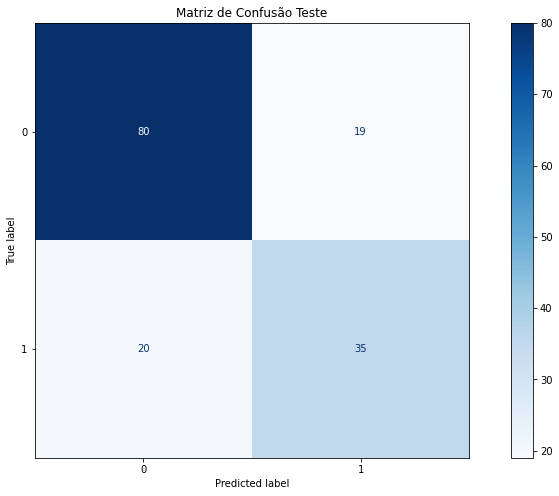

In [454]:
## plotando Matriz de confusão do teste
f, ax = plt.subplots(1,1,figsize=(15,8))

plot_confusion_matrix(rf,x_test,y_test,ax=ax,cmap=plt.cm.Blues,values_format='.4g')

ax.set_title('Matriz de Confusão Teste')

plt.show()

In [456]:
# matrix de confusão com precisão, recall, f1-scope e support do treino
y_pred_train_rf = rf.predict(x_train)
print(confusion_matrix(y_train, y_pred_train_rf))
print(classification_report(y_train, y_pred_train_rf))

[[386  15]
 [ 36 177]]
              precision    recall  f1-score   support

           0       0.91      0.96      0.94       401
           1       0.92      0.83      0.87       213

    accuracy                           0.92       614
   macro avg       0.92      0.90      0.91       614
weighted avg       0.92      0.92      0.92       614



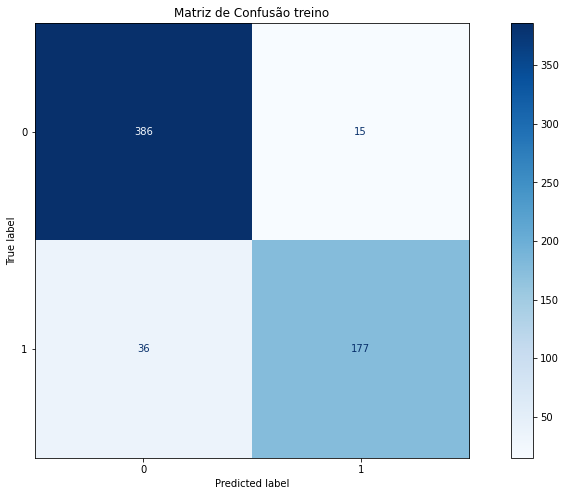

In [459]:
## plotando Matriz de confusão do teste
f, ax = plt.subplots(1,1,figsize=(15,8))

plot_confusion_matrix(rf,x_train,y_train,ax=ax,cmap=plt.cm.Blues,values_format='.4g')

ax.set_title('Matriz de Confusão treino')

plt.show()

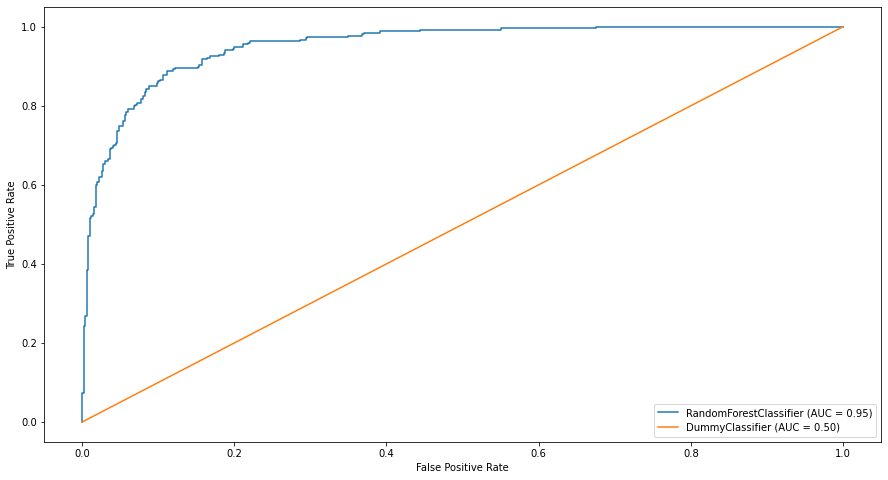

In [457]:
f, ax = plt.subplots(1,1,figsize=(15,8))
plot_roc_curve(rf,x,y,ax=ax)
plot_roc_curve(DummyClassifier('most_frequent').fit(x_train,y_train),x,y,ax=ax)
plt.show()

Gráfico ROC demonstra e eficiência do modelo comparado ao modelo dummy, seu AUC de 0.95 demonstra um maior acerto da target em relação ao 0.50 do modelo dummy.

Após utilizar o GridSearchCV para buscar os melhores parâmetros, o modelo de treino deixou de acertar 100% dos casos, diminuindo sua característica de overfit. já o modelo de teste apresentou melhores resultados no modelo de Random Forest, sendo esse escolhido para representar o modelo, e não o Decision Tree.  